# LDC Spritz 

Lets try to make a PSD for the LDC Spritz 

In [50]:
import numpy as np
import jax

jax.config.update("jax_enable_x64", True)
np.random.seed(0)

f = "/Users/avaj0001/Downloads/drive-download-20250430T050734Z-1-001/LDC-2b-Spritz-MBHB1.asc"
data = np.loadtxt(f, skiprows=2).T
t, X, Y, Z = data


X = X[:535552]
time = t[:535552]
gap_mask = X == 0
gap_mask = gap_mask[:535552]


# standardise X
SCALING = np.std(X)
X = (X - np.mean(X)) / SCALING

In [8]:
import os


from pywavelet import set_backend
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from scipy.signal.windows import tukey
from copy import deepcopy

import glob
from PIL import Image

set_backend("jax")

from pywavelet.transforms import from_freq_to_wavelet
from pywavelet.transforms import from_wavelet_to_freq
from pywavelet.types import Wavelet, FrequencySeries, TimeSeries
import jax.numpy as jnp

plot_dir = "out_spritz"
os.makedirs(plot_dir, exist_ok=True)


def make_gif_from_images(image_regex, gif_name, duration=3):
    images = []
    files = glob.glob(image_regex)
    files = sorted(
        files,
        key=lambda x: int(os.path.basename(x).split("_")[1].split(".")[0]),
    )
    for filename in files:
        images.append(Image.open(filename))
    images[0].save(
        gif_name,
        save_all=True,
        append_images=images[1:],
        duration=duration * 1000,  # Convert seconds to milliseconds
        loop=0,
    )

[12:06:52] WARNING  JAX SUBPACKAGE NOT FULLY TESTED                                                   ]8;id=333799;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=355058;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#5\5]8;;\

           INFO     Jax running on cpu [32bit precision].                                            ]8;id=84376;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=682258;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#21\21]8;;\

           WARNING  Jax is not running in 64bit precision. To change, use                            ]8;id=990030;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=400301;file:///Users/avaj0001/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#23\23]8;;\
                    jax.config.update('jax_enable_x64', True).                                                     

ts ND : 535552
wnm ND : 535552
MAD thresholding -- deleting values > nsigma (9.00)* MAD
Percentage of data masked: 3.17%
ts ND : 535552, wnm ND: 535552
N Gaps: 10080
Filling gaps with generated noise
BEFORE
2.8030794625010573


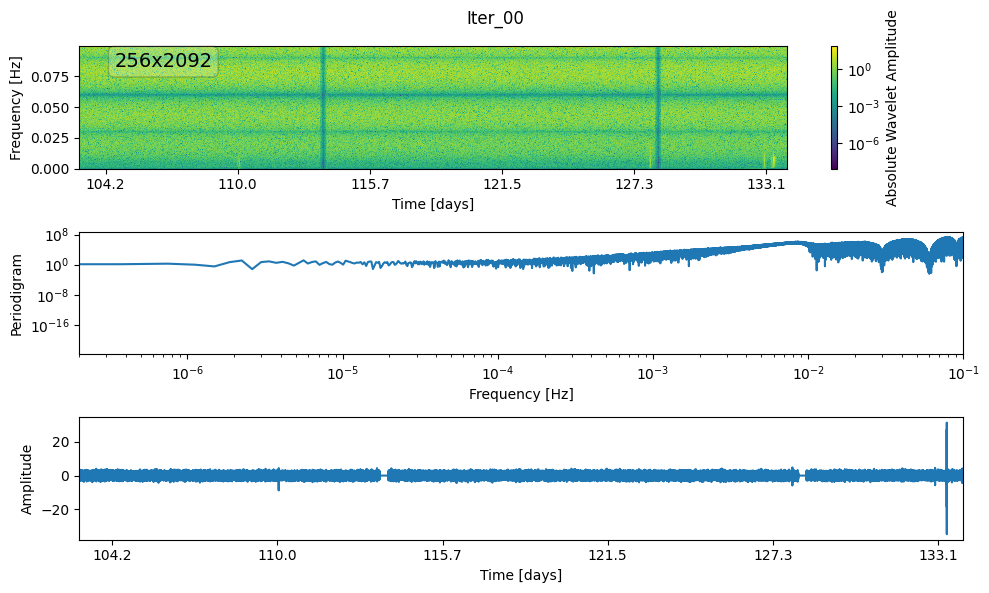

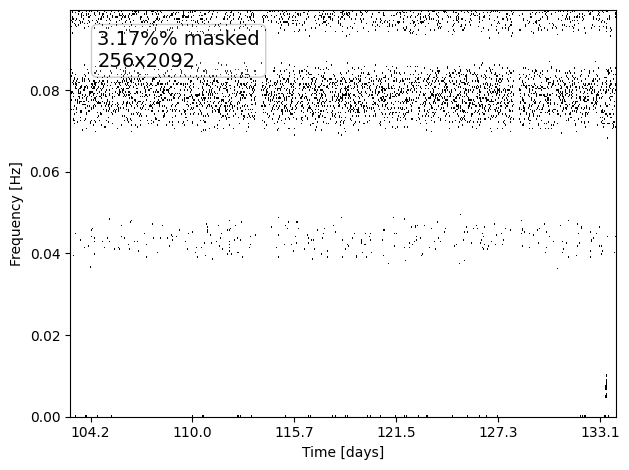

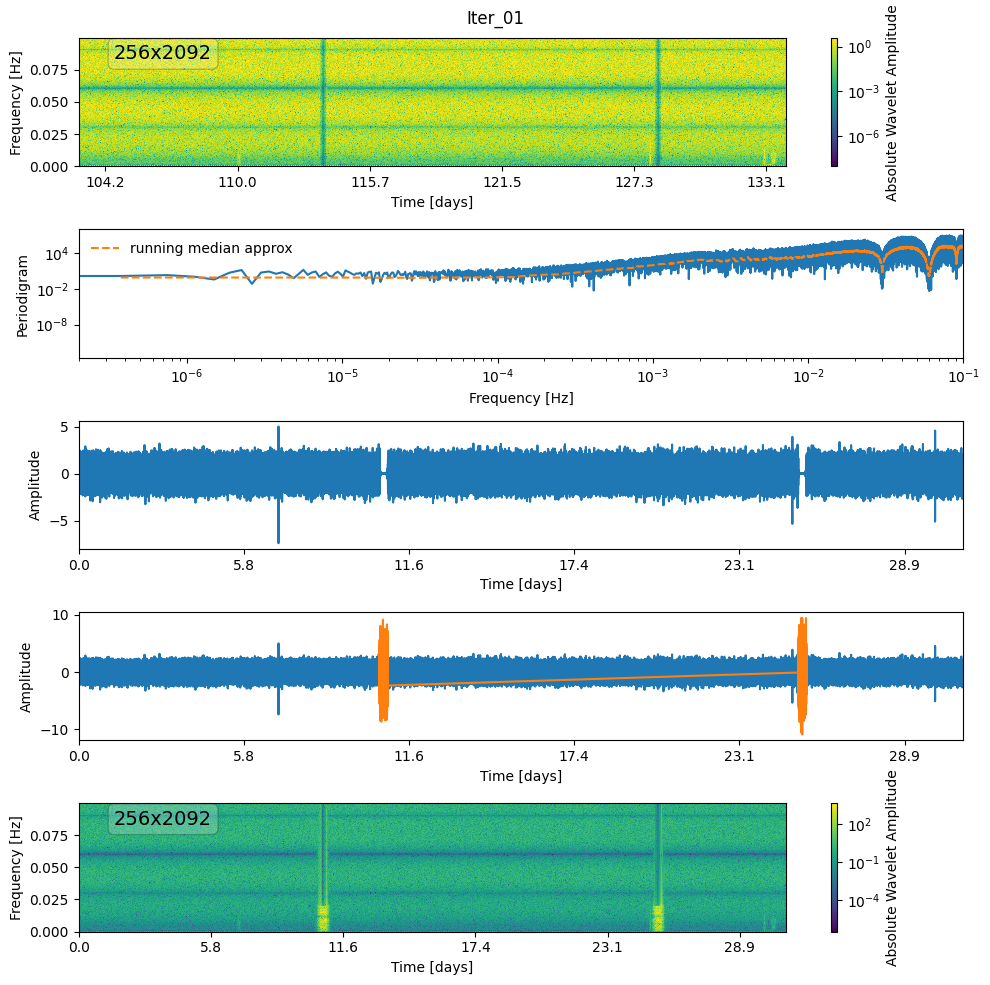

In [53]:
def plot_wnm_and_ts(
    timeseries,
    freqseries,
    wnm,
    label="spritz",
    psd_approx=None,
    ax=None,
    save=True,
):
    if ax is None:
        fig, ax = plt.subplots(3, 1, figsize=(10, 6))

    wnm.plot(zscale="log", absolute=True, ax=ax[0])

    freqseries.plot_periodogram(ax=ax[1])
    if psd_approx is not None:
        psd_approx.plot(ax[1], scaling=1e5)

    ax[1].legend(frameon=False)

    timeseries.plot(ax=ax[2])

    fig = ax[1].get_figure()
    fig.suptitle(label)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(plot_dir, f"{label}.png"))


def plot_mask(wnm, mask, label="mask"):
    mask_wnm = deepcopy(wnm)
    mask_wnm.data = mask_wnm.data.at[mask].set(1)  # set outliers to 1 (masked)
    mask_wnm.data = mask_wnm.data.at[~mask].set(
        0
    )  # set non-outliers to 0 (unmasked -- we keep)
    d = wnm.data.ravel()
    percentage = np.sum(mask) / len(d)
    print(f"Percentage of data masked: {percentage:.2%}")

    mask_wnm.plot(
        absolute=True,
        cmap="binary",
        show_colorbar=False,
        label=f"{percentage:.2%}% masked",
        zscale="linear",
    )
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f"{label}.png"))


def mad_threshold(wnm: Wavelet, nsigma: float = 5.0) -> Wavelet:
    """
    Sigma-clipping using median and MAD across time for each frequency bin.
    """
    print(f"MAD thresholding -- deleting values > nsigma ({nsigma:.2f})* MAD")

    wnm_copy = deepcopy(wnm)
    data = jnp.abs(wnm.data)
    # median and MAD
    median = jnp.median(data)
    mad = jnp.median(np.abs(data - median))

    # mask outliers (True = outlier)
    mask = np.abs(data - median) > nsigma * mad
    wnm_copy.data = wnm_copy.data.at[mask].set(median)
    return wnm_copy, mask


def generate_noise_from_psd(noise_psd, freqs, n_samples):
    white_noise_fft = (
        np.random.normal(size=len(freqs))
        + 1j * np.random.normal(size=len(freqs))
    ) / np.sqrt(2)
    white_noise_fft[0] /= np.sqrt(2)  # Adjust DC component
    # Scale amplitude by sqrt(n_samples) to match the PSD normalization with np.fft.irfft
    colored_noise_fft = white_noise_fft * np.sqrt(noise_psd * n_samples)
    noise_time = np.fft.irfft(colored_noise_fft, n=n_samples)
    return noise_time


def denoise(wnm, thr, gap_mask, i=0):

    wnm, mask = mad_threshold(wnm, nsigma=thr * 10)
    plot_mask(wnm, mask, label=f"mask-{i}")

    # plot each iteration
    fs = wnm.to_frequencyseries()
    ts = fs.to_timeseries()

    psd_approx = PSDApprox.fit(ts)

    fig, ax = plt.subplots(5, 1, figsize=(10, 10))
    plot_wnm_and_ts(
        ts,
        fs,
        wnm,
        label=f"Iter_{i + 1:02d}",
        psd_approx=psd_approx,
        ax=ax,
        save=False,
    )

    print(f"ts ND : {ts.ND}, wnm ND: {wnm.ND}")
    print("N Gaps:", np.sum(gap_mask))
    print("Filling gaps with generated noise")

    # fill in gap
    generated_noise = generate_noise_from_psd(
        psd_approx.power * 1e2, psd_approx.freq, ts.ND
    )
    generated_noise = generated_noise.reshape(-1, 1).T[0]
    generated_noise = generated_noise[: len(ts.data)]

    # fill in the gaps
    time_data = np.array(ts.data)

    print("BEFORE")
    print(np.std(generated_noise))
    # scale the generated_noise to match the original ts.data
    # generated_noise = generated_noise * np.std(ts.data[0:100]) + np.mean(ts.data[0:100])
    # print(np.std(generated_noise))
    time_data[gap_mask] = generated_noise[gap_mask] * 1e2

    new_ts = TimeSeries(time_data, time=ts.time)
    new_wnm = new_ts.to_frequencyseries().to_wavelet(Nf=256)

    ts.plot(ax[3])
    ax[3].plot(
        ts.time[gap_mask],
        generated_noise[gap_mask],
        color="tab:orange",
        label="generated noise",
    )
    # new_ts.plot(ax[3], color='tab:orange', alpha=0.5)
    new_wnm.plot(zscale="log", absolute=True, ax=ax[4])
    plt.savefig(
        os.path.join(
            plot_dir,
            f"Iter_{i + 1:02d}",
        )
    )

    return wnm


def iterative_denoise(
    wnm: Wavelet,
    gap_mask,
    iterations: int = 5,
    base_threshold: float = 0.3,
    decay: float = 0.9,
) -> Wavelet:
    """
    Iteratively apply thresholding, decaying the threshold each time.
    method: 'global', 'mad', or 'blockwise'
    """
    new_wnm = deepcopy(wnm)
    for i in range(iterations):
        thr = base_threshold * (decay**i)
        new_wnm = denoise(wnm, thr, gap_mask, i)

    return new_wnm


ts = TimeSeries(X[:535552], time=t[:535552])
print(f"ts ND : {ts.ND}")


fs = ts.to_frequencyseries()
orig_wnm = fs.to_wavelet(Nf=256)
plot_wnm_and_ts(ts, fs, orig_wnm, label="Iter_00")

wnm = fs.to_wavelet(Nf=256)
print(f"wnm ND : {wnm.ND}")
# psd_approx = PSDApprox.fit(ts)
#
# generated_noise = generate_noise_from_psd(psd_approx.power, psd_approx.freq, ts.ND)


wnm = iterative_denoise(
    wnm, gap_mask, iterations=1, base_threshold=0.9, decay=0.9
)
# make_gif_from_images(os.path.join(plot_dir, 'Iter_*.png'), os.path.join(plot_dir, 'wnm_psd_gen.gif'), duration=0.5)

In [43]:
# gap_mask = ts.data == 0
# ts.m

AttributeError: 'TimeSeries' object has no attribute 'm'

BEFORE
0.8844361892657235


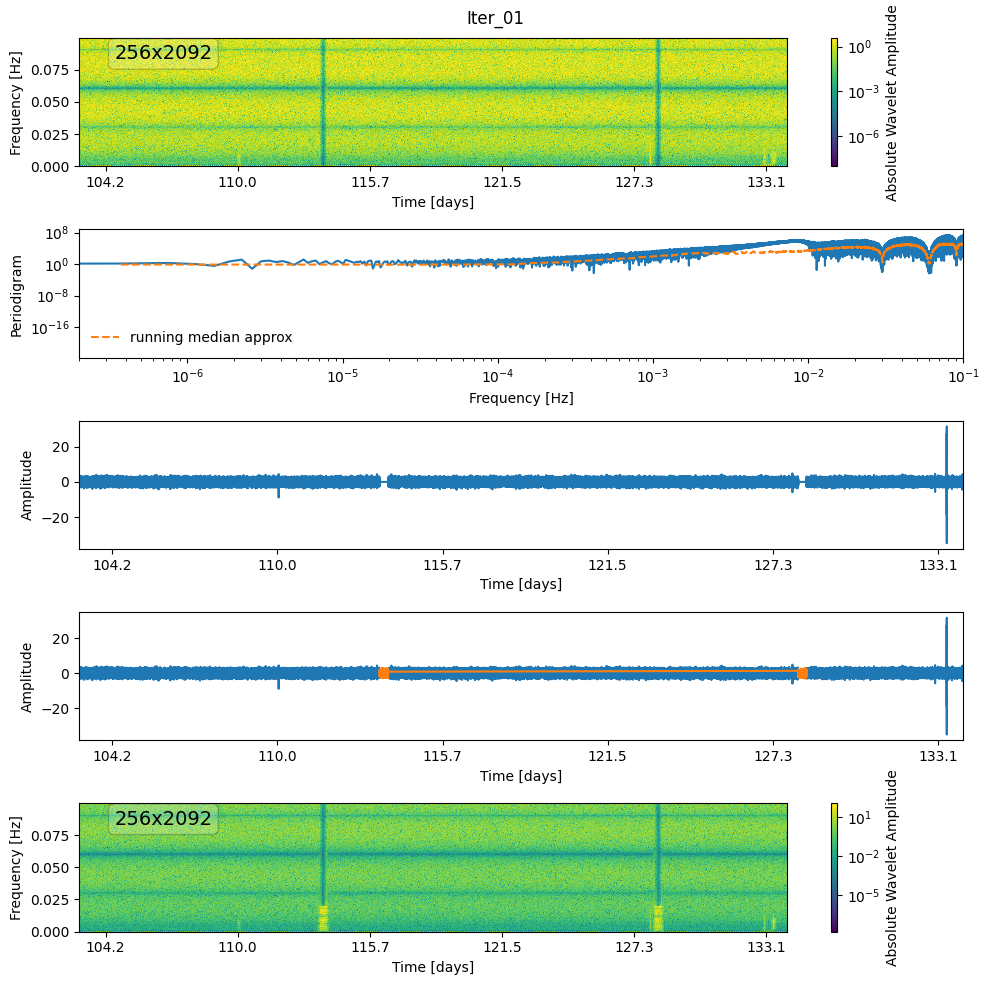

In [52]:
# i = 0
# wnm, mask = mad_threshold(wnm, nsigma=10)
#
# # plot each iteration
# fs = wnm.to_frequencyseries()
# ts = fs.to_timeseries()
#
# psd_approx = PSDApprox.fit(ts)
#


fig, ax = plt.subplots(5, 1, figsize=(10, 10))
plot_wnm_and_ts(
    ts,
    fs,
    wnm,
    label=f"Iter_{i + 1:02d}",
    psd_approx=psd_approx,
    ax=ax,
    save=False,
)


# fill in gap
generated_noise = generate_noise_from_psd(
    psd_approx.power * 1e1, psd_approx.freq, ts.ND
)
generated_noise = generated_noise.reshape(-1, 1).T[0]
generated_noise = generated_noise[: len(ts.data)]


# fill in the gaps
time_data = np.array(ts.data)

print("BEFORE")
print(np.std(generated_noise))
# scale the generated_noise to match the original ts.data
# generated_noise = generated_noise * np.std(ts.data[0:100]) + np.mean(ts.data[0:100])
# print(np.std(generated_noise))
time_data[gap_mask] = generated_noise[gap_mask] * 1e1


new_ts = TimeSeries(time_data, time=ts.time)
new_wnm = new_ts.to_frequencyseries().to_wavelet(Nf=256)

ts.plot(ax[3])
ax[3].plot(
    ts.time[gap_mask],
    generated_noise[gap_mask],
    color="tab:orange",
    label="generated noise",
)
# new_ts.plot(ax[3], color='tab:orange', alpha=0.5)
new_wnm.plot(zscale="log", absolute=True, ax=ax[4])
plt.savefig(
    os.path.join(
        plot_dir,
        f"Iter_{i + 1:02d}",
    )
)

In [49]:
ts.time[gap_mask]

array([], dtype=float64)

In [57]:
np.std(ts.data)

np.float64(1.2227757197604746e-20)

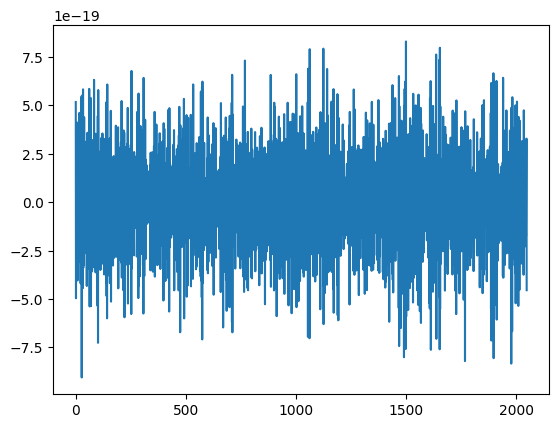

In [22]:
generated_noise = generate_noise_from_psd(
    psd_approx.power * 1e5, psd_approx.freq, 2048
)
plt.plot(generated_noise * 1e-18)

ValueError: x and y must have same first dimension, but have shapes (535552,) and (2048,)

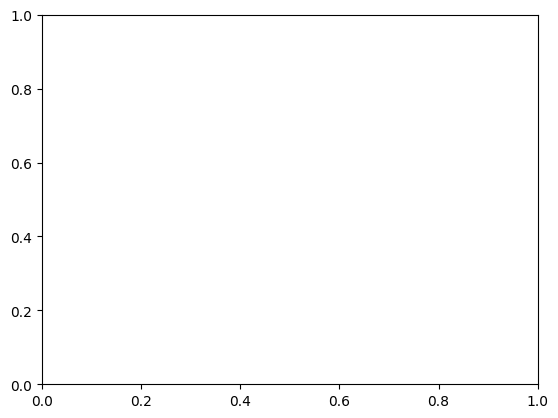

In [54]:
plt.plot(ts.time, np.array(generated_noise * 1e-20))
# plt.scatter(ts.time[gap_mask], generated_noise[gap_mask], color="tab:orange", zorder=10)

## Fitting PSD

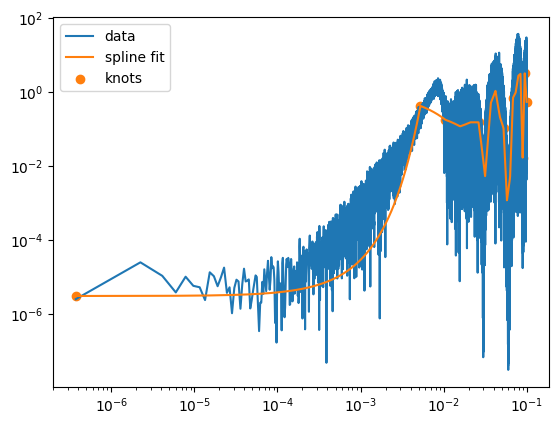

In [4]:
import jax
import jax.numpy as jnp
import optax
from typing import Tuple


def fit_psd_spline_jax(
    freqs: jnp.ndarray,  # shape [N]
    psd_obs: jnp.ndarray,  # shape [N]
    n_knots: int = 20,
    lr: float = 1e-3,
    steps: int = 200,
    log_eps: float = 1e-12,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    knots = jnp.linspace(freqs[0], freqs[-1], n_knots)
    log_true = jnp.log(psd_obs + log_eps)
    init_knot_logs = jnp.interp(knots, freqs, log_true)

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(init_knot_logs)

    def loss_and_grads(knot_logs):
        pred = jnp.interp(freqs, knots, knot_logs)
        loss = jnp.mean((pred - log_true) ** 2)
        grads = jax.grad(
            lambda kl: jnp.mean((jnp.interp(freqs, knots, kl) - log_true) ** 2)
        )(knot_logs)
        return loss, grads

    def step(i, state):
        knot_logs, opt_state = state
        loss, grads = loss_and_grads(knot_logs)
        updates, opt_state = optimizer.update(grads, opt_state)
        knot_logs = optax.apply_updates(knot_logs, updates)
        return (knot_logs, opt_state)

    # training loop
    knot_logs_final, _ = jax.jit(
        lambda kl, os: jax.lax.fori_loop(0, steps, step, (kl, os))
    )(init_knot_logs, opt_state)

    log_psd_fit = jnp.interp(freqs, knots, knot_logs_final)
    return jnp.exp(log_psd_fit), knot_logs_final, knots


std = np.std(ts.data)
mean = np.mean(ts.data)
ynorm = (ts.data - mean) / std
sampling_freq = float(1 / (ts.time[1] - ts.time[0]))
freq = np.fft.rfftfreq(len(ynorm), d=1 / sampling_freq)
power = np.abs(jnp.fft.rfft(ynorm)) ** 2 / len(ynorm)

freq = freq[1::5]
power = power[1::5]

psd_fit, fitted_logs, knots = fit_psd_spline_jax(freq, power)

# then you can plot
import matplotlib.pyplot as plt

plt.loglog(freq, power, label="data")
plt.loglog(freq, psd_fit, label="spline fit")
plt.scatter(knots, jnp.exp(fitted_logs), color="C1", label="knots")
plt.legend()
plt.show()

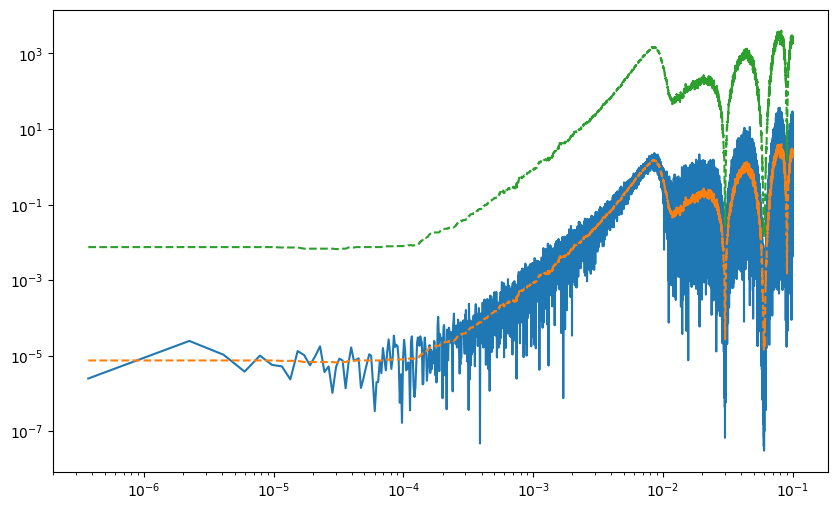

In [17]:
import jax
import jax.numpy as jnp
from jax import lax

import jax
import jax.numpy as jnp
from jax import lax


from dataclasses import dataclass


@dataclass
class PSDApprox:
    freq: jnp.array
    power: jnp.array

    @classmethod
    def fit(cls, ts, window_size=101):
        """
        Calculates a running median approximation of the Power Spectral Density (PSD)
        from a periodogram.

        Args:
          periodogram: A JAX array representing the periodogram.
          window_size: An integer representing the size of the running median window.
                       Must be odd.

        Returns:
          A JAX array representing the running median PSD approximation.
        """

        std = np.std(ts.data)
        mean = np.mean(ts.data)
        ynorm = (ts.data - mean) / std
        sampling_freq = float(1 / (ts.time[1] - ts.time[0]))
        freq = np.fft.rfftfreq(len(ynorm), d=1 / sampling_freq)
        power = np.abs(jnp.fft.rfft(ynorm)) ** 2 / len(ynorm)

        freq = freq[1::5]
        periodogram = power[1::5]
        periodogram = jnp.array(periodogram, dtype=jnp.float64)

        if window_size % 2 == 0:
            raise ValueError("Window size must be odd for running median.")

        padding = window_size // 2
        padded_periodogram = jnp.pad(
            periodogram, (padding, padding), mode="reflect"
        )

        def median_window(i):
            window = jax.lax.dynamic_slice(
                padded_periodogram, (i,), (window_size,)
            )
            return jnp.median(jnp.sort(window))

        n = periodogram.shape[0]
        indices = jnp.arange(n)
        running_median = jax.vmap(median_window)(indices)

        # rescale the running median to have the same power as the original
        running_median = running_median

        return cls(freq=freq, power=running_median * std**2)

    def plot(self, ax, scaling=1):
        p = np.array(self.power) * scaling
        ax.loglog(self.freq, p, label="running median approx", linestyle="--")


psd_approx = PSDApprox.fit(ts)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.loglog(freq, power, label="Data")
psd_approx.plot(ax)
psd_approx.plot(ax, scaling=1e3)

ValueError: x and y must have same first dimension, but have shapes (53568,) and (267841,)

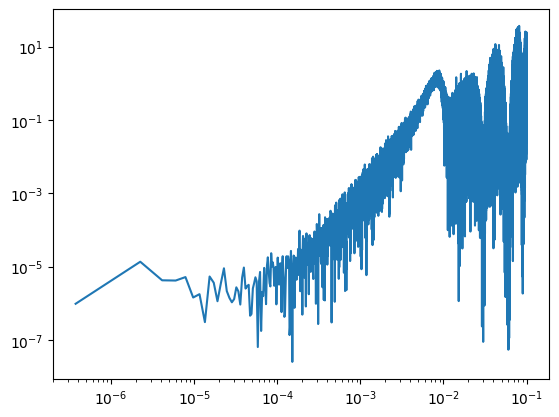

In [8]:
psd_approx = running_median_psd_approximation(fs.periodogram, window_size=101)


plt.loglog(freq, power, label="spline fit")
plt.plot(freq, psd_approx, label="running median approx", linestyle="--")

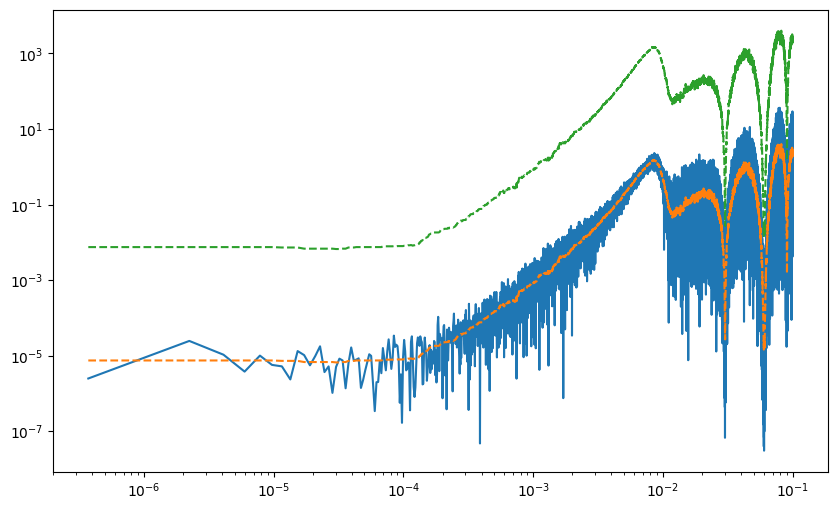

In [65]:
psd_approx = PSDApprox.fit(ts)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.loglog(freq, power, label="Data")
psd_approx.plot(ax)

In [74]:
%reload_ext autoreload
%autoreload 2

from log_psplines.psplines import LogPSplines, Periodogram
from log_psplines.datasets import Timeseries as PsplinesTimeseries
from log_psplines.plotting import plot_pdgrm
from log_psplines.mcmc import run_mcmc


def get_basic_psd(ts):
    psd_approx = PSDApprox.fit(ts)

    std = np.std(ts.data)
    mean = np.mean(ts.data)
    ynorm = (ts.data - mean) / std
    new_ts = PsplinesTimeseries(t=ts.time, y=ynorm, std=std)
    periodogram = new_ts.to_periodogram()
    spline_model = LogPSplines.from_periodogram(
        periodogram=periodogram,
        n_knots=30,
        degree=3,
        diffMatrixOrder=2,
        parametric_model=psd_approx.power,
    )
    psd_fit = spline_model() * std**2
    freq = periodogram.freqs
    return freq, psd_fit


#
# freq, psd = get_basic_psd(ts)
# fig, ax = ts.to_frequencyseries().plot_periodogram()
# ax.plot(freq, psd, label='LogPSpline fit', color='red')

#
# # new_ts = new_ts.standardise()
# periodogram = new_ts.to_periodogram()
#
# plot_pdgrm(
#     pdgrm=periodogram
# )
# new_ts.fs

# print(new_ts.std)
#
# plt.plot(new_ts.t, new_ts.y)

psd_approx = PSDApprox.fit(ts)
pgrm = Periodogram(freqs=freq[1::5], power=power[1::5])
approx_pdgrm = Periodogram(
    freqs=freq[1::5], power=(psd_approx.power + 1e-6)[1::5]
)

# periodogram = new_ts.to_periodogram()
# periodogram = periodogram.downsample(factor=2)
spline_model = LogPSplines.from_periodogram(
    periodogram=approx_pdgrm,
    n_knots=40,
    degree=3,
    diffMatrixOrder=2,
    knot_kwargs=dict(frac_log=0.2),
    parametric_model=psd_approx.power[1::5],
)
# psd_fit = spline_model()*std**2
# freq = periodogram.freqs


#
# plot_pdgrm(approx_pdgrm,
#            spline_model=spline_model,)

(<Figure size 400x300 with 1 Axes>,
 <Axes: xlabel='Frequency (Hz)', ylabel='Power'>)

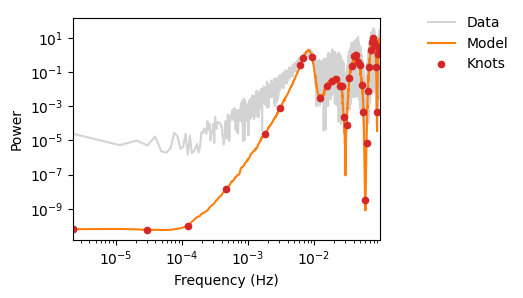

In [75]:
# spline_model.weights = jnp.zeros_like(spline_model.weights)


fig, ax = plot_pdgrm(
    pgrm,
    spline_model=spline_model,
)

In [77]:
spline_model.weights

Array([-1.83805977e-04, -8.91185326e-04, -3.50013510e-03, -1.41638674e-02,
       -4.68858779e-02, -5.48335022e-02, -8.07325358e-02, -4.11451571e-02,
       -2.90809579e-02,  1.35925098e-02,  1.89796170e-03, -1.22993804e-01,
       -4.31864295e-02, -6.86834892e-02, -2.76254263e-02, -5.92031779e-02,
       -3.12930658e-02, -1.45095947e-01, -1.69640967e-01, -9.97554737e-03,
       -3.66073730e-02,  8.64408365e-04,  4.08797426e-03, -1.64652760e-02,
       -5.38484879e-03, -9.39892661e-02, -4.52676155e-02, -3.97503113e-01,
       -1.78027318e-01, -5.50896853e-02, -2.90669526e-02,  1.80494641e-02,
        2.39938545e-02,  3.91933908e-02,  3.06856455e-02,  2.16521871e-02,
       -3.09561810e-04, -1.92035073e-01,  6.27716268e-02, -1.60554802e-02,
        3.00683515e-02,  3.03128060e-03], dtype=float64)

In [87]:
import time

# approx_pdgrm = approx_pdgrm.downsample(10)

t0 = time.time()
samples, spline_model = run_mcmc(
    pgrm,
    parametric_model=psd_approx.power[1::5],
    n_knots=40,
    num_samples=500,
    num_warmup=500,
)


runtime = float(time.time()) - t0


fig, ax = plot_pdgrm(pgrm, spline_model, sampler.get_samples()["weights"])
fig.savefig(os.path.join(plot_dir, f"test_mcmc.png"))

Spline model: LogPSplines(knots=40, degree=3, n=10711)


sample: 100%|██████████| 1000/1000 [05:59<00:00,  2.78it/s, 1023 steps of size 5.86e-04. acc. prob=0.93]


NameError: name 'sampler' is not defined

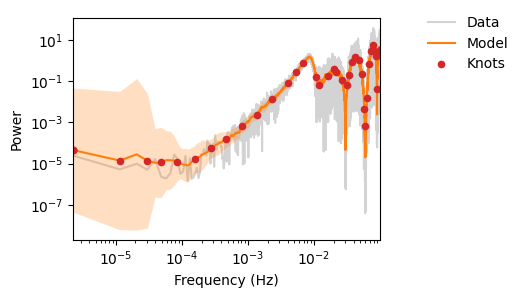

In [88]:
fig, ax = plot_pdgrm(pgrm, spline_model, samples.get_samples()["weights"])
fig.savefig(os.path.join(plot_dir, f"test_mcmc.png"))

(0.0001, np.float64(0.0999925310707457))

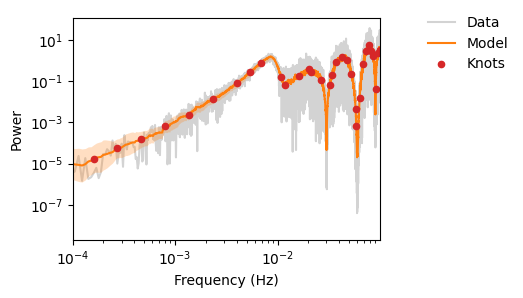

In [91]:
fig, ax = plot_pdgrm(pgrm, spline_model, samples.get_samples()["weights"])
ax.set_xlim(left=10e-5)
# fig.savefig(os.path.join(plot_dir, f"test_mcmc.png"))

In [ ]:
new_ts = PsplinesTimeseries(t=ts.time, y=ts.data)
new_ts.standardise()
periodogram = new_ts.to_periodogram()

In [76]:
import jax
import jax.numpy as jnp
import optax

logP = jnp.log(power + 1e-6)  # log-PSD (add eps to avoid log(0))

# Define knots for piecewise-linear fit on [0,0.5]
num_knots = 40
knots = jnp.linspace(freq[0], freq[-1], num_knots)
# Initialize spline coefficients (values at knots)
coefs = jnp.zeros(num_knots)

# Hyperparameters: smoothing penalty weight
lambda_penalty = 1e-2


def loss_fn(coefs, freq, logP):
    # Linear interpolation of coefs at frequencies
    y_pred = jnp.interp(freq, knots, coefs)
    # Mean squared error on log-PSD
    mse = jnp.mean((y_pred - logP) ** 2)
    # Second-difference penalty
    pen = lambda_penalty * jnp.sum(jnp.diff(coefs, 2) ** 2)
    return mse + pen


# Use Optax to minimize the loss
optimizer = optax.adam(learning_rate=0.1)
opt_state = optimizer.init(coefs)


@jax.jit
def train_step(coefs, opt_state, freq, logP):
    loss, grads = jax.value_and_grad(loss_fn)(coefs, freq, logP)
    updates, opt_state = optimizer.update(grads, opt_state)
    coefs = optax.apply_updates(coefs, updates)
    return coefs, opt_state, loss


# Run a few training iterations
for i in range(500):
    coefs, opt_state, loss = train_step(coefs, opt_state, freq, logP)
# The fitted smooth log-PSD is:
logP_smooth_spline = jnp.interp(freq, knots, coefs)

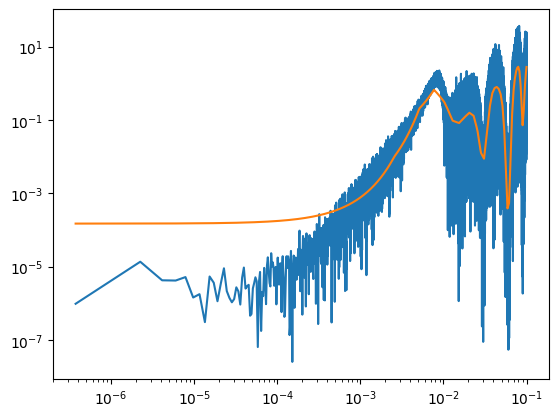

In [46]:
plt.loglog(freq, power)
plt.loglog(freq, jnp.exp(logP_smooth_spline), label="spline fit")

In [35]:
gap_mask

array([False, False, False, ..., False, False, False])